In [1]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
img = cv2.imread("idcard1.jpg")

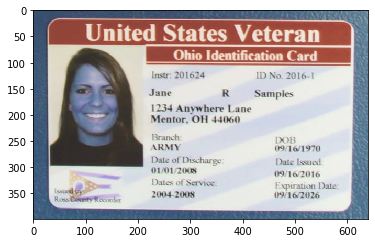

In [3]:
plt.imshow(img)

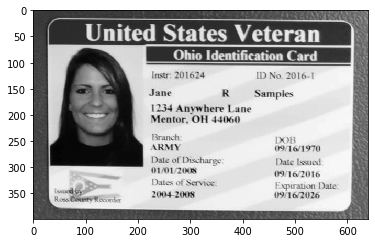

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [5]:
th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)

In [6]:
result = pytesseract.image_to_string((threshed), lang='eng')

In [7]:
result

'See\n\nree States eon\n\n  \n     \n \n  \n  \n\nVane R Samples\n\n234 Anywhere bane\nMentor OH 44000\n\nARMY Sie ten\n\nnn\n\n        \n\napo. ye\n\x0c'

In [8]:
for word in result.split("\n"):
    if "-" in word:
        word = word.replace("-", ":")
    
    if "PATIENT ID" in word:
        patient_id = word.split()
    print(word)

See

ree States eon

  
     
 
  
  

Vane R Samples

234 Anywhere bane
Mentor OH 44000

ARMY Sie ten

nn

        

apo. ye



### ID CARD

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pytesseract
import cv2
import matplotlib.pyplot as plt
import dlib
import matplotlib.patches as mpatches
from skimage import io,draw,transform,color
import numpy as np
import pandas as pd
import re

/home/aksultan/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


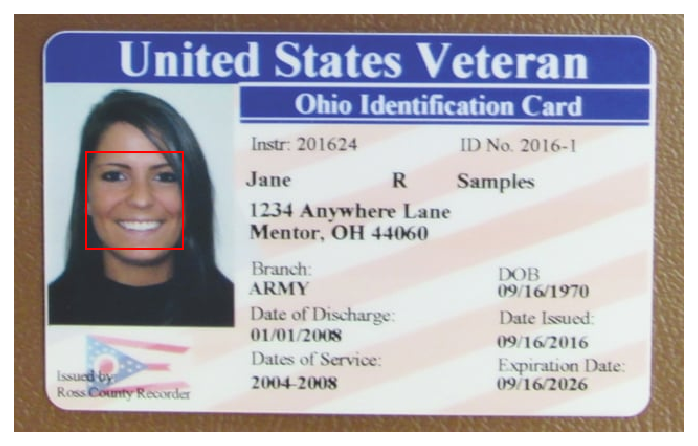

In [10]:
detector = dlib.get_frontal_face_detector()
image = io.imread("idcard1.jpg")
dets = detector(image, 2)

plt.figure()
ax = plt.subplot(111)
ax.imshow(image)
plt.axis("off")
for i, face in enumerate(dets):
    left = face.left()
    top = face.top()
    right = face.right()
    bottom = face.bottom()
    rect = mpatches.Rectangle((left,bottom), right - left, top - bottom,
                                  fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
plt.show()

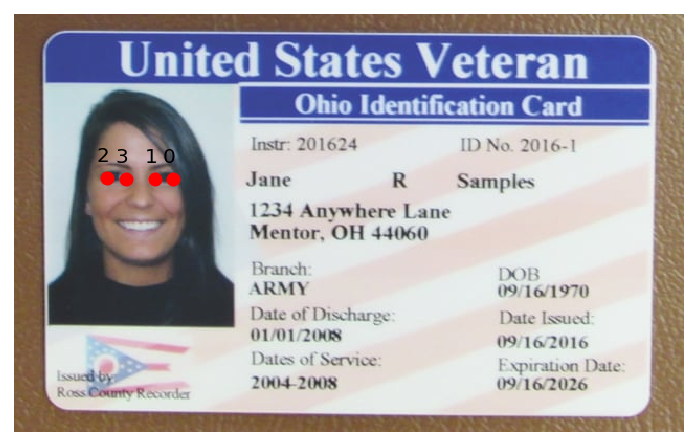

In [11]:
predictor = dlib.shape_predictor("shape_predictor_5_face_landmarks.dat")
detected_landmarks = predictor(image, dets[0]).parts()
landmarks = np.array([[p.x, p.y] for p in detected_landmarks])
plt.figure()
ax = plt.subplot(111)
ax.imshow(image)
plt.axis("off")
plt.plot(landmarks[0:4,0],landmarks[0:4,1],'ro')
for ii in np.arange(4):
    plt.text(landmarks[ii,0]-10,landmarks[ii,1]-15,ii)
plt.show()

In [12]:
def twopointcor(point1,point2):
    """point1 = (x1,y1),point2 = (x2,y2)"""
    deltxy = point2 - point1
    corner = np.arctan(deltxy[1] / deltxy[0]) * 180 / np.pi
    return corner

corner10 =  twopointcor(landmarks[1,:],landmarks[0,:])
corner23 =  twopointcor(landmarks[3,:],landmarks[2,:])
corner20 =  twopointcor(landmarks[2,:],landmarks[0,:])
corner = np.mean([corner10,corner23,corner20])
print(corner10)
print(corner23)
print(corner20)
print(corner)

0.0
3.179830119864234
0.9093804491991414
1.363070189687792


In [13]:
def IDcorner(landmarks):
    corner20 = twopointcor(landmarks[2,:],landmarks[0,:])
    corner = np.mean([corner20])
    return corner
corner = IDcorner(landmarks)
print(corner)

0.9093804491991414


In [14]:
def rotateIdcard(image):
    detector = dlib.get_frontal_face_detector()
    dets = detector(image, 2)
    predictor = dlib.shape_predictor("shape_predictor_5_face_landmarks.dat")
    detected_landmarks = predictor(image, dets[0]).parts()
    landmarks = np.array([[p.x, p.y] for p in detected_landmarks])
    corner = IDcorner(landmarks)

    image2 = transform.rotate(image,corner,clip=False)
    image2 = np.uint8(image2*255)

    det = detector(image2, 2)
    return image2,det

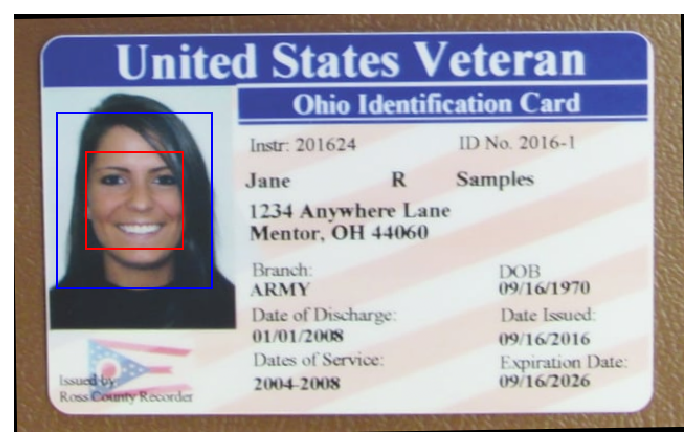

In [15]:
image = io.imread("idcard1.jpg")
image2,dets = rotateIdcard(image)

plt.figure()
ax = plt.subplot(111)
ax.imshow(image2)
plt.axis("off")

left = dets[0].left()
top = dets[0].top()
right = dets[0].right()
bottom = dets[0].bottom()
rect = mpatches.Rectangle((left,bottom), (right - left), (top - bottom),
                          fill=False, edgecolor='red', linewidth=1)
ax.add_patch(rect)

width = right - left
high = top - bottom
left2 = np.uint(left - 0.3*width)
bottom2 = np.uint(bottom + 0.4*width)
rect = mpatches.Rectangle((left2,bottom2), 1.6*width, 1.8*high,
                          fill=False, edgecolor='blue', linewidth=1)
ax.add_patch(rect)
plt.show()

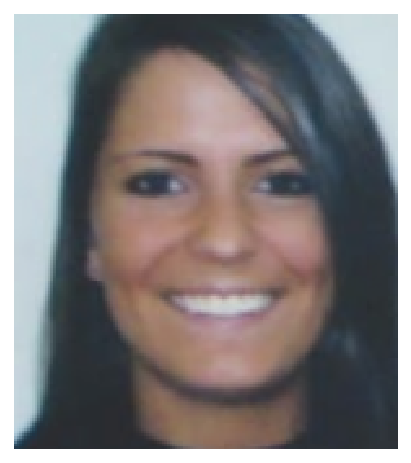

In [16]:
top2 = np.uint(bottom2+1.8*high)
right2 = np.uint(left2+1.6*width)
image3 = image2[top2:bottom2,left2:right2,:]
plt.imshow(image3)
plt.axis("off")
plt.show()

In [17]:
cv2.imwrite("filename.png", image3)

True

In [18]:
text = pytesseract.image_to_string(image2,lang='eng')
print(text)

Instr: 201624 ) No. 2016.

Jane R Samples

1234 Anywhere Lane

Mentor, OH 44060

ARMY 09/16/1970
Date of Discharge Date Issued
01/01/2008 09/16/2016
dates of Service

2004-2008 09/1620)

 



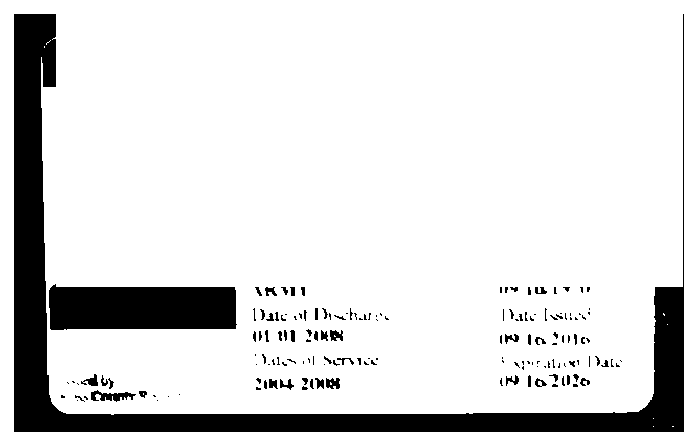

In [19]:
imagegray = cv2.cvtColor(image2,cv2.COLOR_RGB2GRAY)
retval, imagebin = cv2.threshold(imagegray, 120, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

imagebin[0:bottom2,left2:-1] = 255
plt.imshow(imagebin,cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [20]:
textlist = text.split("\n")
textdf = pd.DataFrame({"text":textlist})
textdf["textlen"] = textdf.text.apply(len)
textdf = textdf[textdf.textlen > 1].reset_index(drop = True)
textdf

,text,textlen
0,Instr: 201624 ) No. 2016.,25
1,Jane R Samples,14
2,1234 Anywhere Lane,18
3,"Mentor, OH 44060",16
4,ARMY 09/16/1970,15
5,Date of Discharge Date Issued,29
6,01/01/2008 09/16/2016,21
7,dates of Service,16
8,2004-2008 09/1620),18
